In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.stats import zscore
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
import tensorflow as tf

from scipy import signal

## Valid data

In [3]:
base_dir = 'data/PlantSounds'

categories = [
    'Tomato Dry',
    'Empty Pot',
    'Greenhouse Noises',
    'Tobacco Cut',
    'Tobacco Dry',
    'Tomato Cut'
]

for category in categories:
    path = os.path.join(base_dir, category)
    if os.path.exists(path):
        print(f"{path}, {len(os.listdir(path))} items")
    else:
        print(f"{path} does not exist!")

data/PlantSounds/Tomato Dry, 1622 items
data/PlantSounds/Empty Pot, 1036 items
data/PlantSounds/Greenhouse Noises, 1378 items
data/PlantSounds/Tobacco Cut, 506 items
data/PlantSounds/Tobacco Dry, 275 items
data/PlantSounds/Tomato Cut, 660 items


## Feature Extraction Methods

### 1.1 Deep Scattering Network

Implement using ScatNet with Morlet wavelets

Input: 2ms sound segment at 500 kHz (1000 sample points)

Output: Feature vector of transformed coefficients

In [4]:


def morlet_wavelet(width, omega):
    """Create a Morlet wavelet function"""
    x = np.linspace(-width/2, width/2, width)
    envelope = np.exp(-x**2/(2*(width/8)**2))
    wavelet = envelope * np.exp(1j * omega * x)
    return wavelet

def create_wavelet_filters(n_wavelets_per_octave, n_octaves, sample_rate, q_factor=1, max_width=None):
    """Create a bank of Morlet wavelets filters with limited width"""
    filters = []

    # Base frequency
    min_freq = 20  # Hz
    max_freq = sample_rate / 2  # Nyquist frequency

    # Calculate frequencies
    n_filters = n_wavelets_per_octave * n_octaves
    freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), n_filters)

    for freq in freqs:
        # Calculate width based on Q-factor
        width = int(sample_rate * q_factor / freq)
        # Ensure width is odd
        if width % 2 == 0:
            width += 1
        # Ensure width is not too small or too large
        width = max(width, 5)
        if max_width is not None:
            width = min(width, max_width)

        # Create wavelet
        omega = 2 * np.pi * freq / sample_rate
        wavelet = morlet_wavelet(width, omega)

        # Convert to TensorFlow tensor
        wavelet_tensor = tf.convert_to_tensor(wavelet, dtype=tf.complex64)
        filters.append(wavelet_tensor)

    return filters

def convolve_tf(x, f):
    """Safely convolve signal x with filter f using FFT"""
    # Ensure f is not longer than x
    if tf.shape(f)[0] > tf.shape(x)[0]:
        f = f[:tf.shape(x)[0]]

    # Zero-pad f to match x's length
    padded_f = tf.concat([f, tf.zeros(tf.shape(x)[0] - tf.shape(f)[0], dtype=f.dtype)], axis=0)

    # Perform convolution via FFT
    fft_x = tf.signal.fft(tf.cast(x, tf.complex64))
    fft_f = tf.signal.fft(padded_f)
    conv = tf.signal.ifft(fft_x * fft_f)

    return conv

def scatter_transform_layer(x, filters, lowpass_filter):
    """Apply scattering transform for one layer"""
    outputs = []
    modulus_outputs = []

    # Apply each wavelet filter
    for f in filters:
        # Complex convolution
        conv = convolve_tf(x, f)

        # Calculate modulus
        modulus = tf.abs(conv)
        modulus_outputs.append(modulus)

        # Apply lowpass filter to smooth
        lowpass_real = tf.cast(lowpass_filter, tf.complex64)
        smoothed_complex = convolve_tf(modulus, lowpass_real)
        smoothed = tf.abs(smoothed_complex)

        outputs.append(smoothed)

    return outputs, modulus_outputs

def create_lowpass_filter(width, cutoff, sample_rate):
    """Create a lowpass filter"""
    nyquist = sample_rate / 2
    normalized_cutoff = cutoff / nyquist
    filt = signal.firwin(width, normalized_cutoff)
    return tf.convert_to_tensor(filt, dtype=tf.float32)

def extract_features_from_transform(transform_outputs, n_features=100):
    """Extract fixed number of features from transform outputs"""
    features = []

    # For each filter output, compute statistics
    for output in transform_outputs:
        output_np = output.numpy()
        features.append(np.mean(output_np))
        features.append(np.std(output_np))
        features.append(np.max(output_np))

        # Add some frequency domain features
        fft_mag = np.abs(np.fft.rfft(output_np))
        if len(fft_mag) > 0:
            features.append(np.mean(fft_mag))
            features.append(np.max(fft_mag))
            # Add spectral centroid
            if np.sum(fft_mag) > 0:
                indices = np.arange(len(fft_mag))
                centroid = np.sum(indices * fft_mag) / np.sum(fft_mag)
                features.append(centroid)
            else:
                features.append(0)
        else:
            # Pad with zeros if FFT is empty
            features.extend([0, 0, 0])

    # Ensure we have exactly n_features
    features = np.array(features)
    if len(features) >= n_features:
        # Truncate if we have too many
        return features[:n_features]
    else:
        # Pad with zeros if we don't have enough
        padded = np.zeros(n_features)
        padded[:len(features)] = features
        return padded

def deep_scattering_transform(audio, sample_rate=500000, n_layers=2,
                             lowpass_width=2**8, q_factor=1, n_wavelets_per_octave=8):
    """Apply deep scattering transform to audio"""
    # Convert to TensorFlow tensor
    x = tf.convert_to_tensor(audio, dtype=tf.float32)
    signal_length = tf.shape(x)[0]

    # Limit wavelet width
    max_wavelet_width = signal_length.numpy() // 2

    # Create wavelet filters - limit number to save computation
    n_octaves = min(int(np.log2(sample_rate / 20)), 6)  # Reduce octaves to limit filters
    n_wavelets_per_octave = min(n_wavelets_per_octave, 4)  # Limit wavelets per octave

    filters = create_wavelet_filters(n_wavelets_per_octave, n_octaves, sample_rate,
                                    q_factor, max_width=max_wavelet_width)

    # Create lowpass filter
    lowpass_width = min(lowpass_width, signal_length.numpy() // 2)
    lowpass_cutoff = 100  # Hz
    lowpass_filter = create_lowpass_filter(lowpass_width, lowpass_cutoff, sample_rate)

    # First layer
    layer1_outputs, layer1_modulus = scatter_transform_layer(x, filters, lowpass_filter)
    all_outputs = layer1_outputs

    # Second layer (if requested)
    if n_layers >= 2:
        # Limit computation by using fewer modulus outputs
        max_second_layer = min(len(layer1_modulus), 3)  # Only use first few modulus outputs
        for i in range(max_second_layer):
            layer2_out, _ = scatter_transform_layer(layer1_modulus[i], filters[:max_second_layer], lowpass_filter)
            all_outputs.extend(layer2_out)

    return all_outputs

def extract_scatnet_features(file_path, segment_duration=0.002, target_sr=500000, n_features=100):
    """Extract ScatNet features from an audio file"""
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=target_sr)

        # Ensure we have enough samples
        expected_samples = int(segment_duration * target_sr)
        if len(audio) < expected_samples:
            audio = np.pad(audio, (0, expected_samples - len(audio)))

        # Use just the first segment
        audio = audio[:expected_samples]

        # Apply scattering transform
        transform_outputs = deep_scattering_transform(
            audio,
            sample_rate=target_sr,
            n_layers=2,
            lowpass_width=min(2**8, expected_samples // 4),
            q_factor=1,
            n_wavelets_per_octave=8
        )

        # Extract fixed number of features
        features = extract_features_from_transform(transform_outputs, n_features)

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        # Return zero vector as fallback
        return np.zeros(n_features)


Testing with file: data/PlantSounds/Tomato Dry/id_33_sound_4.wav
Audio loaded: 1001 samples at 500000Hz (duration: 0.002s)
Feature shape: (100,)
Feature min: 0.0011, max: 6.3316, mean: 0.6802


2025-04-13 14:36:12.891702: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-13 14:36:12.891892: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-13 14:36:12.891904: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-13 14:36:12.891946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-13 14:36:12.892159: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


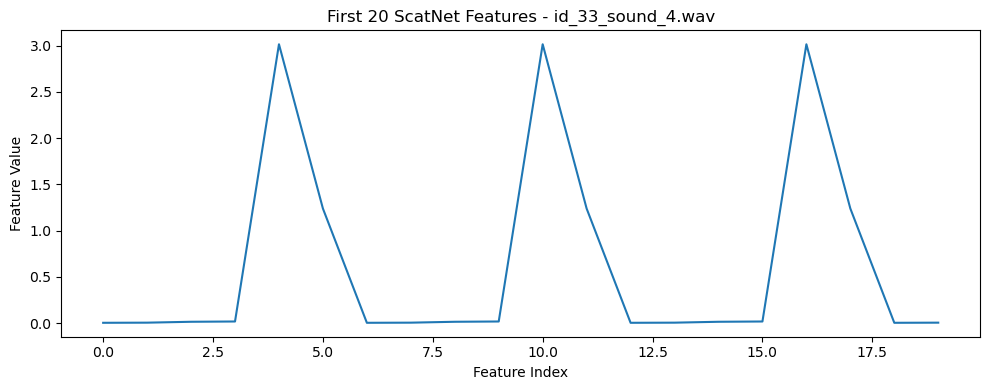

ScatNet feature extraction test completed successfully!


array([3.01532052e-03, 4.46861889e-03, 1.41018303e-02, 1.70839164e-02,
       3.01532044e+00, 1.23855896e+00, 3.01525299e-03, 4.46859887e-03,
       1.41017772e-02, 1.70837958e-02, 3.01525298e+00, 1.23857723e+00,
       3.01510002e-03, 4.46855370e-03, 1.41016589e-02, 1.70835242e-02,
       3.01510014e+00, 1.23861919e+00, 3.01475357e-03, 4.46845125e-03,
       1.41013898e-02, 1.70829052e-02, 3.01475350e+00, 1.23868857e+00,
       3.01396661e-03, 4.46822029e-03, 1.41007807e-02, 1.70815038e-02,
       3.01396668e+00, 1.23886451e+00, 3.01218289e-03, 4.46770340e-03,
       1.40994061e-02, 1.70783376e-02, 3.01218308e+00, 1.23928908e+00,
       3.00815934e-03, 4.46656346e-03, 1.40963383e-02, 1.70712308e-02,
       3.00815934e+00, 1.24024724e+00, 2.99919210e-03, 4.46412712e-03,
       1.40896365e-02, 1.70555493e-02, 2.99919194e+00, 1.24251416e+00,
       2.97990604e-03, 4.45924141e-03, 1.40757496e-02, 1.70224808e-02,
       2.97990620e+00, 1.24813701e+00, 2.94258422e-03, 4.45058895e-03,
      

In [5]:
def test_scatnet_feature_extraction():
    """Test ScatNet feature extraction on a sample file"""
    # Find the first available audio file
    audio_file = None
    for category in categories:
        path = os.path.join(base_dir, category)
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if f.endswith('.wav')]
            if files:
                audio_file = os.path.join(path, files[0])
                break

    if audio_file is None:
        print("No audio files found!")
        return

    print(f"Testing with file: {audio_file}")

    # Load audio to see what we're working with
    try:
        audio, sr = librosa.load(audio_file, sr=None)
        print(f"Audio loaded: {len(audio)} samples at {sr}Hz (duration: {len(audio)/sr:.3f}s)")

        # Extract features
        features = extract_scatnet_features(
            audio_file,
            segment_duration=0.002,
            target_sr=500000,
            n_features=100
        )

        print(f"Feature shape: {features.shape}")
        print(f"Feature min: {features.min():.4f}, max: {features.max():.4f}, mean: {features.mean():.4f}")

        # Plot first 20 features to reduce clutter
        plt.figure(figsize=(10, 4))
        plt.plot(features[:20])
        plt.title(f"First 20 ScatNet Features - {os.path.basename(audio_file)}")
        plt.xlabel("Feature Index")
        plt.ylabel("Feature Value")
        plt.tight_layout()
        plt.show()

        print("ScatNet feature extraction test completed successfully!")
        return features
    except Exception as e:
        print(f"Error during feature extraction: {e}")
        import traceback
        traceback.print_exc()

test_scatnet_feature_extraction()


### 1.2 MFCC (Mel-frequency cepstral coefficients)
- Apply windowing with 1ms Hamming windows and 0.5ms overlap
- Normalize features using Z-score normalization

In [10]:
from sklearn.preprocessing import StandardScaler

def extract_mfcc_features(file_path,
                         n_mfcc=13,
                         n_mels=40,
                         window_length_ms=1,
                         hop_length_ms=0.5,
                         normalize=True):
    """
    Extract MFCC features from an audio file with specified configuration

    Parameters:
    -----------
    file_path : str
        Path to audio file
    n_mfcc : int
        Number of MFCC coefficients to extract
    n_mels : int
        Number of Mel filter banks to use
    window_length_ms : float
        Window length in milliseconds
    hop_length_ms : float
        Hop length in milliseconds
    normalize : bool
        Whether to apply Z-score normalization

    Returns:
    --------
    features : ndarray
        Normalized MFCC features (39 coefficients per frame)
    """
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=None)

        # For very short audio files, we need to adjust parameters
        duration_ms = 1000 * len(y) / sr
        print(f"Audio duration: {duration_ms:.2f} ms")

        # Ensure window_length is reasonable for the audio length
        window_length_ms = min(window_length_ms, duration_ms / 2)
        hop_length_ms = min(hop_length_ms, window_length_ms / 2)

        # Convert window and hop lengths from ms to samples
        window_length = max(int(window_length_ms * sr / 1000), 4)  # Ensure at least 4 samples
        hop_length = max(int(hop_length_ms * sr / 1000), 2)       # Ensure at least 2 samples

        print(f"Using window_length={window_length} samples, hop_length={hop_length} samples")

        # Ensure window_length is even (required by librosa)
        if window_length % 2 != 0:
            window_length += 1

        # For very short files, we might need to pad the signal to get enough frames
        if len(y) < 3 * window_length:
            padding = 3 * window_length - len(y)
            y = np.pad(y, (0, padding), mode='constant')
            print(f"Padded audio to {len(y)} samples")

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=n_mfcc,
            n_mels=n_mels,
            win_length=window_length,
            hop_length=hop_length,
            window='hamming'
        )

        print(f"MFCC shape: {mfccs.shape}")

        # If we have too few frames for delta calculation, reduce the width parameter
        width = min(9, max(3, mfccs.shape[1] - 2))  # Width must be odd and <= frame count
        width = width if width % 2 == 1 else width - 1  # Ensure width is odd

        print(f"Using delta width={width}")

        # Calculate delta and delta-delta features with adjusted width
        delta_mfccs = librosa.feature.delta(mfccs, width=width)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2, width=width)

        # Combine all features
        features = np.concatenate([mfccs, delta_mfccs, delta2_mfccs], axis=0)

        # Transpose to have features as rows (frames × features)
        features = features.T

        # Apply Z-score normalization if requested
        if normalize and features.shape[0] > 1:  # Need multiple frames for normalization
            scaler = StandardScaler()
            features = scaler.fit_transform(features)

        return features

    except Exception as e:
        print(f"Error extracting MFCC features from {file_path}: {e}")
        import traceback
        traceback.print_exc()
        # Return a single frame of zero features
        return np.zeros((1, n_mfcc * 3))

In [11]:
def summarize_mfcc_features(features):
    """Summarize MFCC features by computing statistics across frames"""
    if features.shape[0] <= 1:
        # If we have only one frame, just return it
        return features.flatten()

    # Compute statistics across frames
    mean_features = np.mean(features, axis=0)
    std_features = np.std(features, axis=0)
    max_features = np.max(features, axis=0)
    min_features = np.min(features, axis=0)

    # Combine statistics into one feature vector
    summary = np.concatenate([mean_features, std_features, max_features, min_features])

    return summary

Testing MFCC extraction with file: data/PlantSounds/Tomato Dry/id_33_sound_4.wav
Audio loaded: 1001 samples at 500000Hz (duration: 0.002s)
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio to 1500 samples
MFCC shape: (13, 7)
Using delta width=5
MFCC feature shape: (7, 39) (frames × features)
Feature min: -2.2756, max: 2.3873, mean: -0.0000
Summary feature shape: (156,)


/opt/anaconda3/envs/nyu-machine-learning-tf/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1500
  warnings.warn(


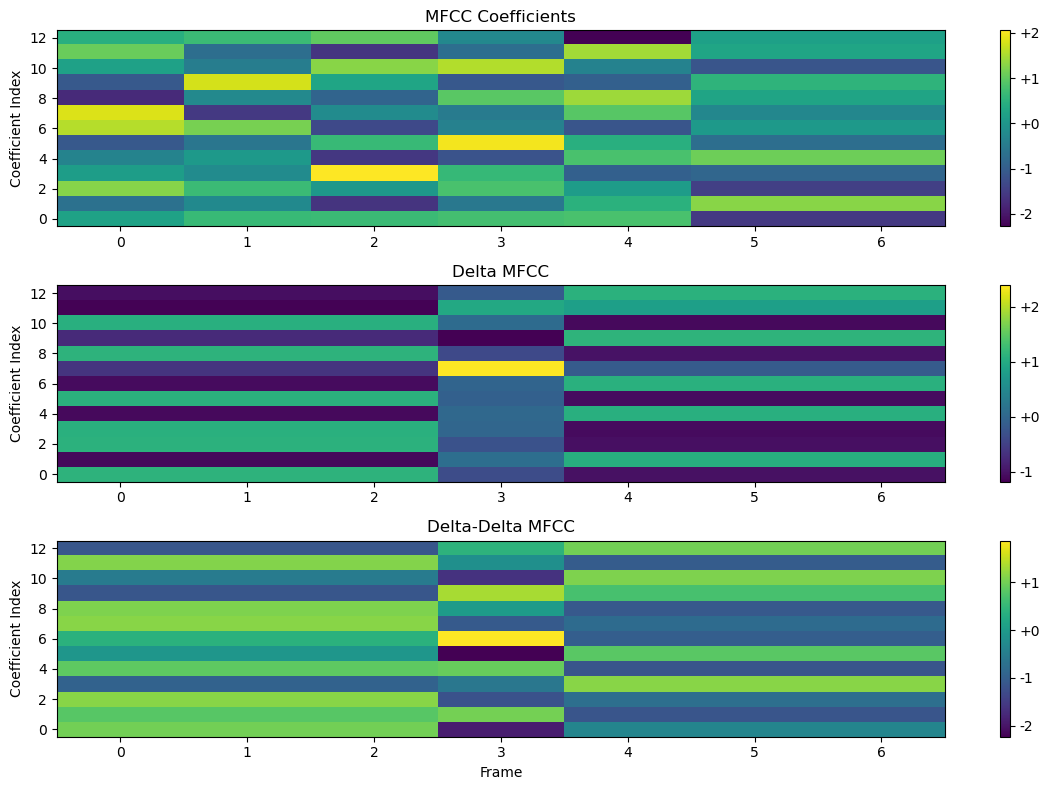

MFCC feature extraction test completed successfully!


array([[ 2.2445370e-01, -6.6440117e-01,  1.2749254e+00,  1.4291228e-01,
        -3.3177492e-01, -1.0597451e+00,  1.5747709e+00,  1.8217851e+00,
        -1.7642167e+00, -1.0733249e+00,  2.1018130e-01,  1.0609047e+00,
         4.6066034e-01,  1.1266690e+00, -1.0965198e+00,  1.1197224e+00,
         1.0802308e+00, -1.0849257e+00,  1.0946046e+00, -1.0758299e+00,
        -6.3966572e-01,  1.1315402e+00, -7.5048989e-01,  1.0684448e+00,
        -1.1534560e+00, -1.0501992e+00,  9.9595010e-01,  8.1134200e-01,
         1.1410619e+00, -9.4648206e-01,  8.4929657e-01, -7.0258617e-02,
         3.8332585e-01,  1.1497948e+00,  1.0760201e+00, -1.1273350e+00,
        -5.2962905e-01,  1.1092694e+00, -1.1348583e+00],
       [ 6.3910019e-01, -2.2700527e-01,  6.7554408e-01, -1.8453977e-01,
         7.4919917e-02, -5.8261675e-01,  1.1584585e+00, -1.5517612e+00,
        -2.3801994e-01,  1.7682496e+00, -4.4005176e-01, -7.1789157e-01,
         6.8346798e-01,  1.1266690e+00, -1.0965198e+00,  1.1197224e+00,
       

In [12]:
def test_mfcc_feature_extraction():
    """Test MFCC feature extraction on a sample file"""
    # Find the first available audio file
    audio_file = None
    for category in categories:
        path = os.path.join(base_dir, category)
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if f.endswith('.wav')]
            if files:
                audio_file = os.path.join(path, files[0])
                break

    if audio_file is None:
        print("No audio files found!")
        return

    print(f"Testing MFCC extraction with file: {audio_file}")

    # Load audio to see what we're working with
    try:
        audio, sr = librosa.load(audio_file, sr=None)
        duration = len(audio) / sr
        print(f"Audio loaded: {len(audio)} samples at {sr}Hz (duration: {duration:.3f}s)")

        # Extract MFCC features
        features = extract_mfcc_features(
            audio_file,
            n_mfcc=13,
            n_mels=40,
            window_length_ms=1,
            hop_length_ms=0.5,
            normalize=True
        )

        print(f"MFCC feature shape: {features.shape} (frames × features)")
        print(f"Feature min: {features.min():.4f}, max: {features.max():.4f}, mean: {features.mean():.4f}")

        # Summary features for classification
        summary_features = summarize_mfcc_features(features)
        print(f"Summary feature shape: {summary_features.shape}")

        # Plot features if we have more than one frame
        if features.shape[0] > 1:
            plt.figure(figsize=(12, 8))

            # Plot original MFCCs (first 13 coefficients)
            plt.subplot(3, 1, 1)
            plt.imshow(features[:, :13].T, aspect='auto', origin='lower')
            plt.colorbar(format='%+2.0f')
            plt.title('MFCC Coefficients')
            plt.ylabel('Coefficient Index')

            # Plot delta MFCCs
            plt.subplot(3, 1, 2)
            plt.imshow(features[:, 13:26].T, aspect='auto', origin='lower')
            plt.colorbar(format='%+2.0f')
            plt.title('Delta MFCC')
            plt.ylabel('Coefficient Index')

            # Plot delta-delta MFCCs
            plt.subplot(3, 1, 3)
            plt.imshow(features[:, 26:].T, aspect='auto', origin='lower')
            plt.colorbar(format='%+2.0f')
            plt.title('Delta-Delta MFCC')
            plt.xlabel('Frame')
            plt.ylabel('Coefficient Index')

            plt.tight_layout()
            plt.show()
        else:
            # Just plot the feature vector for a single frame
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 1, 1)
            plt.bar(range(features.shape[1]), features[0])
            plt.title('MFCC Features (Single Frame)')
            plt.xlabel('Feature Index')
            plt.ylabel('Feature Value')
            plt.tight_layout()
            plt.show()

        print("MFCC feature extraction test completed successfully!")
        return features
    except Exception as e:
        print(f"Error during MFCC feature extraction: {e}")
        import traceback
        traceback.print_exc()

test_mfcc_feature_extraction()


In [8]:


def train_model(X_train, Y_train, vb=0):
    ### Hyper parameters ###
    batch_size = 64
    num_epochs = 50
    kernel_size = 9
    pool_size = 4
    conv_depth_1 = 32
    conv_depth_2 = 64
    conv_depth_3 = 128
    drop_prob_1 = 0.5
    drop_prob_2 = 0.5
    drop_prob_3 = 0.5
    hidden_size = 128

    ### generating the network ###
    model = Sequential()

    # 1st conv block #
    model.add(Conv1D(conv_depth_1, kernel_size=kernel_size, input_shape=(1001, 1), \
                            padding='same', activation='relu'))
    model.add(Conv1D(conv_depth_1, kernel_size=kernel_size, \
                            padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(drop_prob_1))

    # 2nd conv block #
    model.add(Conv1D(conv_depth_2, kernel_size=kernel_size, \
                            padding='same', activation='relu'))
    model.add(Conv1D(conv_depth_2, kernel_size=kernel_size, \
                            padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(drop_prob_1))

    # 3rd conv block #
    if conv_depth_3 > 0:
        model.add(Conv1D(conv_depth_3, kernel_size=kernel_size, \
                                padding='same', activation='relu'))
        model.add(Conv1D(conv_depth_3, kernel_size=kernel_size, \
                                padding='same', activation='relu'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(drop_prob_3))

    # Dense layers #
    model.add(Flatten())
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dropout(drop_prob_2))
    model.add(Dense(1, activation='sigmoid'))

    # Complie #
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

    # Fit #
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
    model.fit(X_train, Y_train, epochs=num_epochs, \
              batch_size=batch_size, verbose=vb, \
              class_weight={0: class_weights[0], 1: class_weights[1]})

    return model